# Home Exercise 1 on Text Classification

Implement a **Recurrent Neural Network model** (**Vanilla RNN, GRU, and LSTM**) to predict whether a review is positive or negative.

- **Data**: [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) (the last 10% of rows serve as the test set).
- **Compare** the performance of the three models.

**Note**: Submit only a **single Jupyter Notebook file** that can handle all tasks, including data downloading, preprocessing, model training, and model evaluation. *(Submissions that do not follow the guidelines will receive a score of 0.)*

**Grading Criteria**

For valid submissions, scores will be assigned based on the **leaderboard ranking** (**strictly greater**):

- **Top 25%** → **10 points**
- **25% - 50%** → **9.0 points**
- **50% - 75%** → **8.0 points**
- **75% - 100%** → **7.0 points**


# Import Libs

In [1]:
%pip install numpy pandas tensorflow scikit-learn kagglehub nltk matplotlib tqdm


Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import kagglehub
import os
import re
import time 
import string
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

from tqdm import tqdm

# Download necessary NLTK resources
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

allocated = torch.cuda.memory_allocated() / 1024 ** 2  # in MB
reserved = torch.cuda.memory_reserved() / 1024 ** 2

print(f"📦 Allocated Memory: {allocated:.2f} MB")
print(f"📦 Reserved Memory : {reserved:.2f} MB")
print(torch.cuda.memory_summary())


📦 Allocated Memory: 0.00 MB
📦 Reserved Memory : 0.00 MB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       

# Download data

In [4]:
# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

# Define the dataset path (update this if needed)
dataset_file = os.path.join(path, "IMDB Dataset.csv")  # Ensure correct file name

# Load the dataset
df = pd.read_csv(dataset_file)

# Convert sentiments to binary labels
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Define stopwords and chat word dictionary
stop_words = set(stopwords.words("english"))

chat_words = {
    "afaik": "as far as i know", "afk": "away from keyboard", "asap": "as soon as possible",
    "lol": "laughing out loud", "imho": "in my honest opinion", "fyi": "for your information",
    "brb": "be right back", "btw": "by the way", "idk": "i don't know", "ttyl": "talk to you later",
    "omg": "oh my god", "gtg": "got to go", "wtf": "what the f...", "rofl": "rolling on the floor laughing",
    "u": "you", "bff": "best friends forever", "cya": "see you", "jk": "just kidding",
    "idc": "i don't care", "ily": "i love you", "imu": "i miss you"
}

# Function to expand chat words
def expand_chat_words(text, chat_words_dict):
    words = text.split()
    expanded_text = " ".join([chat_words_dict.get(word.upper(), word) for word in words])
    return expanded_text

# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub('<[^<]+?>', '', text)

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

    # Remove punctuations
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Expand chat words
    text = expand_chat_words(text, chat_words)

    # Remove stopwords
    # text = " ".join([word for word in text.split() if word not in stop_words])

    return text

# Apply preprocessing to the dataset
df["cleaned_review"] = df["review"].apply(preprocess_text)

# Split data
# train_texts, test_texts, train_labels, test_labels = train_test_split(df["cleaned_review"], df["sentiment"], test_size=0.1, random_state=42)
# Use the last 10% of the data as the test set (no shuffling)
split_index = int(len(df) * 0.9)
train_texts = df["cleaned_review"].iloc[:split_index]
test_texts = df["cleaned_review"].iloc[split_index:]
train_labels = df["sentiment"].iloc[:split_index]
test_labels = df["sentiment"].iloc[split_index:]

# Tokenization and padding
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 200

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Convert labels to numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Split the training data into training and validation sets (80% - 20%)
train_padded, val_padded, train_labels, val_labels = train_test_split(
    train_padded, train_labels, test_size=0.2, random_state=42
)

# Print the sizes of each set
print(f"Train size: {len(train_padded)}")
print(f"Validation size: {len(val_padded)}")
print(f"Test size (untouched): {len(test_padded)}")


Path to dataset files: /kaggle/input/
Train size: 36000
Validation size: 9000
Test size (untouched): 5000


# Model definition

In [5]:
class EnhancedVanillaRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, dropout_rate=0.5, bidirectional=True):
        super(EnhancedVanillaRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        self.Wxh = nn.Linear(embed_size, hidden_size)
        self.Whh = nn.Linear(hidden_size, hidden_size)
        self.Why = nn.Linear(hidden_size * self.num_directions, output_size)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        embedded = self.embedding(x)
        h_forward = torch.zeros(x.size(0), self.hidden_size).to(x.device)
        
        # Process forward direction
        for t in range(embedded.size(1)):
            h_forward = self.tanh(self.Wxh(embedded[:, t, :]) + self.Whh(h_forward))
        
        if self.bidirectional:
            # Process backward direction
            h_backward = torch.zeros(x.size(0), self.hidden_size).to(x.device)
            for t in reversed(range(embedded.size(1))):
                h_backward = self.tanh(self.Wxh(embedded[:, t, :]) + self.Whh(h_backward))
                
            # Concatenate forward and backward hidden states
            h = torch.cat((h_forward, h_backward), dim=1)
        else:
            h = h_forward
        
        h = self.dropout(h)
        output = self.Why(h)
        
        return output


In [6]:
class EnhancedGRU(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, dropout_rate=0.5, bidirectional=True):
        super(EnhancedGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        
        self.Wz = nn.Linear(embed_size + hidden_size, hidden_size)
        self.Wr = nn.Linear(embed_size + hidden_size, hidden_size)
        self.Wh = nn.Linear(embed_size + hidden_size, hidden_size)
        self.Why = nn.Linear(hidden_size * self.num_directions, output_size)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        embedded = self.embedding(x)
        h_forward = torch.zeros(x.size(0), self.hidden_size).to(x.device)
        
        # Process forward direction
        for t in range(embedded.size(1)):
            concat = torch.cat((embedded[:, t, :], h_forward), dim=1)
            z = self.sigmoid(self.Wz(concat))
            r = self.sigmoid(self.Wr(concat))
            h_tilde = self.tanh(self.Wh(torch.cat((embedded[:, t, :], r * h_forward), dim=1)))
            h_forward = (1 - z) * h_forward + z * h_tilde
        
        if self.bidirectional:
            # Process backward direction
            h_backward = torch.zeros(x.size(0), self.hidden_size).to(x.device)
            for t in reversed(range(embedded.size(1))):
                concat = torch.cat((embedded[:, t, :], h_backward), dim=1)
                z = self.sigmoid(self.Wz(concat))
                r = self.sigmoid(self.Wr(concat))
                h_tilde = self.tanh(self.Wh(torch.cat((embedded[:, t, :], r * h_backward), dim=1)))
                h_backward = (1 - z) * h_backward + z * h_tilde
            
            # Concatenate forward and backward hidden states
            h = torch.cat((h_forward, h_backward), dim=1)
        else:
            h = h_forward
        
        h = self.dropout(h)
        output = self.Why(h)
        
        return output


In [7]:
class EnhancedLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, dropout_rate=0.5, bidirectional=True):
        super(EnhancedLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        
        self.Wf = nn.Linear(embed_size + hidden_size, hidden_size)
        self.Wi = nn.Linear(embed_size + hidden_size, hidden_size)
        self.Wo = nn.Linear(embed_size + hidden_size, hidden_size)
        self.Wc = nn.Linear(embed_size + hidden_size, hidden_size)
        self.Why = nn.Linear(hidden_size * self.num_directions, output_size)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        embedded = self.embedding(x)
        h_forward = torch.zeros(x.size(0), self.hidden_size).to(x.device)
        c_forward = torch.zeros(x.size(0), self.hidden_size).to(x.device)
        
        # Process forward direction
        for t in range(embedded.size(1)):
            concat = torch.cat((embedded[:, t, :], h_forward), dim=1)
            f = self.sigmoid(self.Wf(concat))
            i = self.sigmoid(self.Wi(concat))
            o = self.sigmoid(self.Wo(concat))
            c_tilde = self.tanh(self.Wc(concat))
            
            c_forward = f * c_forward + i * c_tilde
            h_forward = o * self.tanh(c_forward)
        
        if self.bidirectional:
            # Process backward direction
            h_backward = torch.zeros(x.size(0), self.hidden_size).to(x.device)
            c_backward = torch.zeros(x.size(0), self.hidden_size).to(x.device)
            
            for t in reversed(range(embedded.size(1))):
                concat = torch.cat((embedded[:, t, :], h_backward), dim=1)
                f = self.sigmoid(self.Wf(concat))
                i = self.sigmoid(self.Wi(concat))
                o = self.sigmoid(self.Wo(concat))
                c_tilde = self.tanh(self.Wc(concat))
                
                c_backward = f * c_backward + i * c_tilde
                h_backward = o * self.tanh(c_backward)
            
            # Concatenate forward and backward hidden states
            h = torch.cat((h_forward, h_backward), dim=1)
        else:
            h = h_forward
        
        h = self.dropout(h)
        output = self.Why(h)
        
        return output


# Function Defined

In [8]:
def train_model(model, train_loader, val_loader, epochs, lr, clip_value=1.0, print_every=100):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    model.to(device)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        
        for step, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            
            # Gradient Clipping
            nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            # Print progress during training
            if (step + 1) % print_every == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Step [{step+1}/{len(train_loader)}], "
                      f"Loss: {loss.item():.4f}, Accuracy: {correct/total:.4f}")

        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(correct / total)
        
        # Validation Phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for step, (inputs, labels) in enumerate(val_loader):
                inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
                
                # Print progress during validation
                if (step + 1) % print_every == 0:
                    print(f"Validation - Epoch [{epoch+1}/{epochs}], Step [{step+1}/{len(val_loader)}], "
                          f"Loss: {loss.item():.4f}, Accuracy: {val_correct / val_total:.4f}")
        
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_correct / val_total)

        scheduler.step()
        
        print(f"\nEpoch [{epoch+1}/{epochs}] Completed - "
              f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, "
              f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}\n")

    return train_losses, train_accuracies, val_losses, val_accuracies


In [9]:
def plot_performance(train_losses, train_accuracies, val_losses, val_accuracies, model_name):
    epochs = len(train_losses)
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.plot(range(epochs), val_losses, label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(epochs), val_accuracies, label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    plt.show()


In [10]:
def test_model(model, test_loader, model_name, print_every=50):
    model.eval()
    all_preds = []
    all_labels = []
    total_batches = len(test_loader)
    
    with torch.no_grad():
        for step, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Print progress
            if (step + 1) % print_every == 0:
                print(f"Testing - Step [{step+1}/{total_batches}]")
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    
    print(f"\n{model_name} - Test Results:\n"
          f"Accuracy: {accuracy:.4f}\n"
          f"Precision: {precision:.4f}\n"
          f"Recall: {recall:.4f}\n"
          f"F1 Score: {f1:.4f}\n")

    # Print classification report
    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds))
    
    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }


In [11]:
# Function to print model parameters
def print_model_params(model, model_name):
    print(f"\nModel: {model_name}")
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            param_count = param.numel()
            total_params += param_count
            print(f"{name}: {list(param.shape)} - {param_count} params")
    print(f"Total Trainable Parameters: {total_params}\n")

In [12]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Training - Validating - Testing

In [13]:
# Hyperparameters
VOCAB_SIZE = 10000
EMBED_SIZE = 128
HIDDEN_SIZE = 256
OUTPUT_SIZE = 2
EPOCHS = 15
LR = 0.001
BATCH_SIZE = 32

# Initialize Models
vanilla_rnn = EnhancedVanillaRNN(VOCAB_SIZE, EMBED_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
gru = EnhancedGRU(VOCAB_SIZE, EMBED_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device)
lstm = EnhancedLSTM(VOCAB_SIZE, EMBED_SIZE, HIDDEN_SIZE, OUTPUT_SIZE).to(device)


In [14]:
models = {
    "Vanilla RNN": vanilla_rnn,
    "GRU": gru,
    "LSTM": lstm
}

for name, model in models.items():
    print_model_params(model, name)


Model: Vanilla RNN
embedding.weight: [10000, 128] - 1280000 params
Wxh.weight: [256, 128] - 32768 params
Wxh.bias: [256] - 256 params
Whh.weight: [256, 256] - 65536 params
Whh.bias: [256] - 256 params
Why.weight: [2, 512] - 1024 params
Why.bias: [2] - 2 params
Total Trainable Parameters: 1379842


Model: GRU
embedding.weight: [10000, 128] - 1280000 params
Wz.weight: [256, 384] - 98304 params
Wz.bias: [256] - 256 params
Wr.weight: [256, 384] - 98304 params
Wr.bias: [256] - 256 params
Wh.weight: [256, 384] - 98304 params
Wh.bias: [256] - 256 params
Why.weight: [2, 512] - 1024 params
Why.bias: [2] - 2 params
Total Trainable Parameters: 1576706


Model: LSTM
embedding.weight: [10000, 128] - 1280000 params
Wf.weight: [256, 384] - 98304 params
Wf.bias: [256] - 256 params
Wi.weight: [256, 384] - 98304 params
Wi.bias: [256] - 256 params
Wo.weight: [256, 384] - 98304 params
Wo.bias: [256] - 256 params
Wc.weight: [256, 384] - 98304 params
Wc.bias: [256] - 256 params
Why.weight: [2, 512] - 1024 

In [15]:
# Create TensorDatasets
train_data = TensorDataset(torch.tensor(train_padded, dtype=torch.long), torch.tensor(train_labels, dtype=torch.float32))
val_data = TensorDataset(torch.tensor(val_padded, dtype=torch.long), torch.tensor(val_labels, dtype=torch.float32))
test_data = TensorDataset(torch.tensor(test_padded, dtype=torch.long), torch.tensor(test_labels, dtype=torch.float32))

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
results = []

Epoch [1/15], Step [100/1125], Loss: 0.8087, Accuracy: 0.5212
Epoch [1/15], Step [200/1125], Loss: 0.6913, Accuracy: 0.5209
Epoch [1/15], Step [300/1125], Loss: 0.7396, Accuracy: 0.5267
Epoch [1/15], Step [400/1125], Loss: 0.7320, Accuracy: 0.5337
Epoch [1/15], Step [500/1125], Loss: 0.6837, Accuracy: 0.5371
Epoch [1/15], Step [600/1125], Loss: 0.6308, Accuracy: 0.5438
Epoch [1/15], Step [700/1125], Loss: 0.7483, Accuracy: 0.5486
Epoch [1/15], Step [800/1125], Loss: 0.6856, Accuracy: 0.5527
Epoch [1/15], Step [900/1125], Loss: 0.6400, Accuracy: 0.5521
Epoch [1/15], Step [1000/1125], Loss: 0.5518, Accuracy: 0.5495
Epoch [1/15], Step [1100/1125], Loss: 0.7454, Accuracy: 0.5517
Validation - Epoch [1/15], Step [100/282], Loss: 0.5530, Accuracy: 0.6297
Validation - Epoch [1/15], Step [200/282], Loss: 0.6269, Accuracy: 0.6309

Epoch [1/15] Completed - Train Loss: 0.7037, Train Accuracy: 0.5540, Validation Loss: 0.6597, Validation Accuracy: 0.6257

Epoch [2/15], Step [100/1125], Loss: 0.5509,

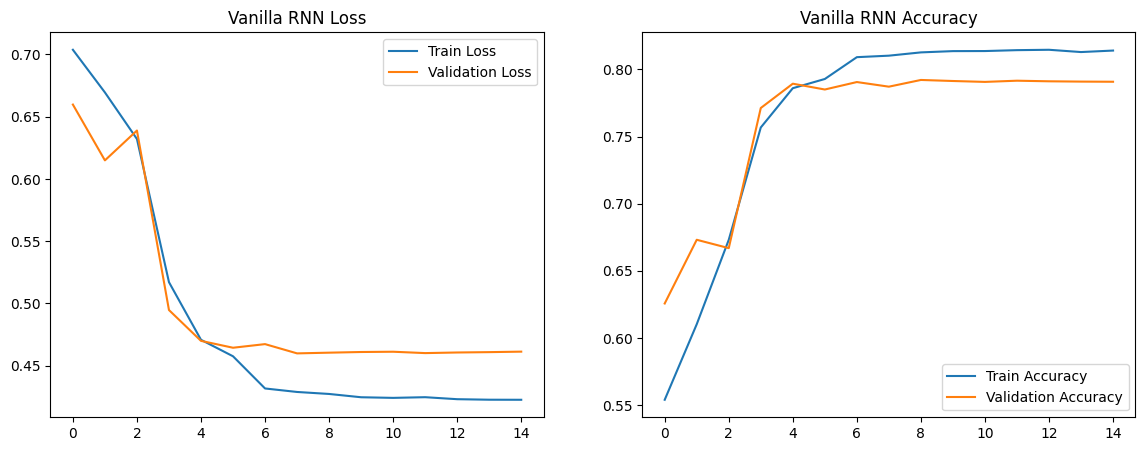

Testing - Step [50/157]
Testing - Step [100/157]
Testing - Step [150/157]

Vanilla RNN - Test Results:
Accuracy: 0.7898
Precision: 0.7846
Recall: 0.7919
F1 Score: 0.7882

Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      2530
           1       0.78      0.79      0.79      2470

    accuracy                           0.79      5000
   macro avg       0.79      0.79      0.79      5000
weighted avg       0.79      0.79      0.79      5000



In [17]:
# Train Vanilla RNN
train_losses_rnn, train_accuracies_rnn, val_losses_rnn, val_accuracies_rnn = train_model(vanilla_rnn, train_loader, val_loader, EPOCHS, LR)
plot_performance(train_losses_rnn, train_accuracies_rnn, val_losses_rnn, val_accuracies_rnn, "Vanilla RNN")
results.append(test_model(vanilla_rnn, test_loader, "Vanilla RNN"))

Epoch [1/15], Step [100/1125], Loss: 0.6533, Accuracy: 0.5428
Epoch [1/15], Step [200/1125], Loss: 0.6501, Accuracy: 0.5505
Epoch [1/15], Step [300/1125], Loss: 0.6130, Accuracy: 0.5692
Epoch [1/15], Step [400/1125], Loss: 0.5609, Accuracy: 0.5856
Epoch [1/15], Step [500/1125], Loss: 0.5761, Accuracy: 0.6064
Epoch [1/15], Step [600/1125], Loss: 0.4871, Accuracy: 0.6261
Epoch [1/15], Step [700/1125], Loss: 0.7012, Accuracy: 0.6430
Epoch [1/15], Step [800/1125], Loss: 0.5107, Accuracy: 0.6579
Epoch [1/15], Step [900/1125], Loss: 0.4753, Accuracy: 0.6716
Epoch [1/15], Step [1000/1125], Loss: 0.5429, Accuracy: 0.6837
Epoch [1/15], Step [1100/1125], Loss: 0.4778, Accuracy: 0.6948
Validation - Epoch [1/15], Step [100/282], Loss: 0.4315, Accuracy: 0.8303
Validation - Epoch [1/15], Step [200/282], Loss: 0.5454, Accuracy: 0.8342

Epoch [1/15] Completed - Train Loss: 0.5687, Train Accuracy: 0.6978, Validation Loss: 0.3770, Validation Accuracy: 0.8326

Epoch [2/15], Step [100/1125], Loss: 0.4459,

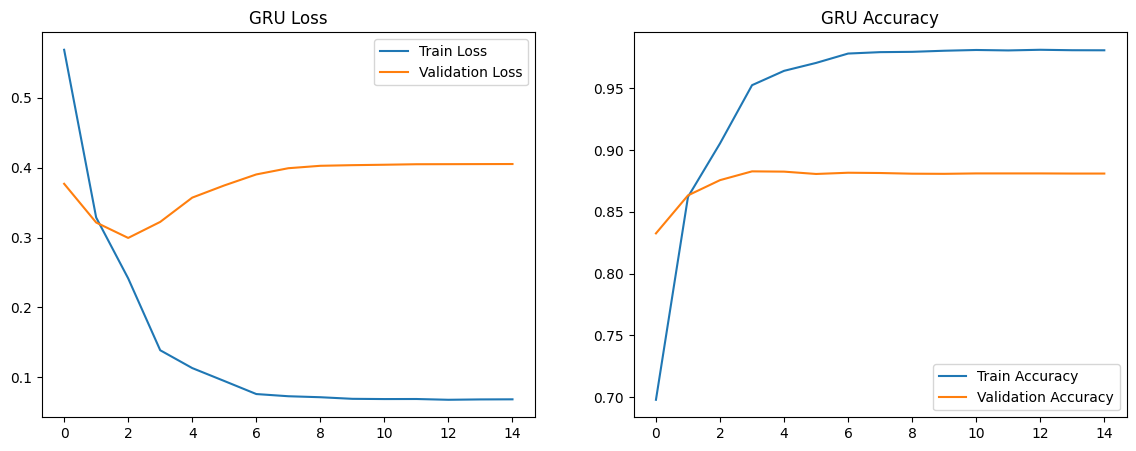

Testing - Step [50/157]
Testing - Step [100/157]
Testing - Step [150/157]

GRU - Test Results:
Accuracy: 0.8776
Precision: 0.8758
Recall: 0.8765
F1 Score: 0.8762

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2530
           1       0.88      0.88      0.88      2470

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



In [18]:
# Train GRU
train_losses_gru, train_accuracies_gru, val_losses_gru, val_accuracies_gru = train_model(gru, train_loader, val_loader, EPOCHS, LR)
plot_performance(train_losses_gru, train_accuracies_gru, val_losses_gru, val_accuracies_gru, "GRU")
results.append(test_model(gru, test_loader, "GRU"))

Epoch [1/15], Step [100/1125], Loss: 0.7036, Accuracy: 0.5200
Epoch [1/15], Step [200/1125], Loss: 0.6525, Accuracy: 0.5470
Epoch [1/15], Step [300/1125], Loss: 0.5706, Accuracy: 0.5598
Epoch [1/15], Step [400/1125], Loss: 0.7956, Accuracy: 0.5709
Epoch [1/15], Step [500/1125], Loss: 0.5303, Accuracy: 0.5911
Epoch [1/15], Step [600/1125], Loss: 0.5474, Accuracy: 0.6044
Epoch [1/15], Step [700/1125], Loss: 0.5057, Accuracy: 0.6172
Epoch [1/15], Step [800/1125], Loss: 0.5069, Accuracy: 0.6310
Epoch [1/15], Step [900/1125], Loss: 0.6310, Accuracy: 0.6414
Epoch [1/15], Step [1000/1125], Loss: 0.7960, Accuracy: 0.6523
Epoch [1/15], Step [1100/1125], Loss: 0.5680, Accuracy: 0.6601
Validation - Epoch [1/15], Step [100/282], Loss: 0.4346, Accuracy: 0.7522
Validation - Epoch [1/15], Step [200/282], Loss: 0.6298, Accuracy: 0.7505

Epoch [1/15] Completed - Train Loss: 0.6165, Train Accuracy: 0.6621, Validation Loss: 0.5220, Validation Accuracy: 0.7486

Epoch [2/15], Step [100/1125], Loss: 0.3642,

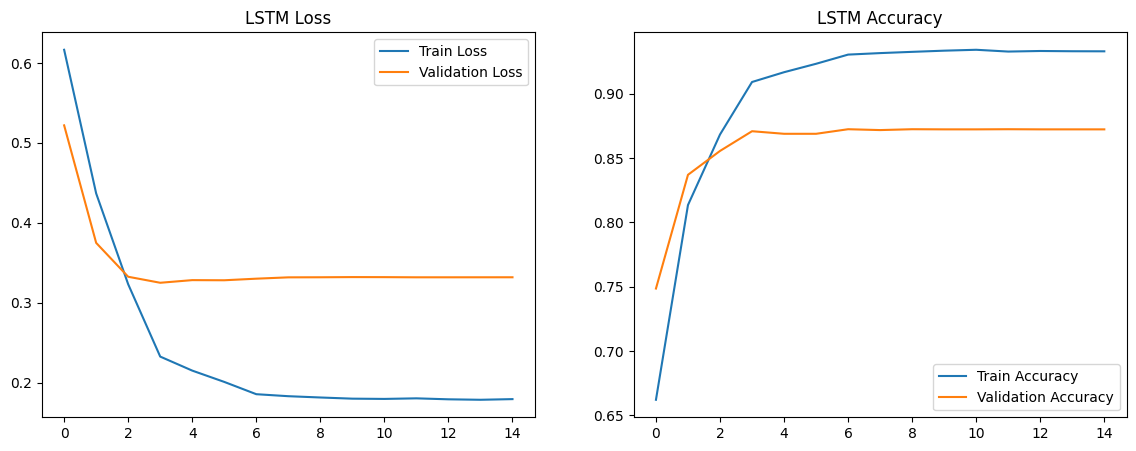

Testing - Step [50/157]
Testing - Step [100/157]
Testing - Step [150/157]

LSTM - Test Results:
Accuracy: 0.8706
Precision: 0.8719
Recall: 0.8652
F1 Score: 0.8685

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      2530
           1       0.87      0.87      0.87      2470

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



In [19]:
# Train LSTM
train_losses_lstm, train_accuracies_lstm, val_losses_lstm, val_accuracies_lstm = train_model(lstm, train_loader, val_loader, EPOCHS, LR)
plot_performance(train_losses_lstm, train_accuracies_lstm, val_losses_lstm, val_accuracies_lstm, "LSTM")
results.append(test_model(lstm, test_loader, "LSTM"))

In [20]:
allocated = torch.cuda.memory_allocated() / 1024 ** 2  # in MB
reserved = torch.cuda.memory_reserved() / 1024 ** 2

print(f"📦 Allocated Memory: {allocated:.2f} MB")
print(f"📦 Reserved Memory : {reserved:.2f} MB")
print(torch.cuda.memory_summary())

📦 Allocated Memory: 51.59 MB
📦 Reserved Memory : 194.00 MB
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  52829 KiB | 166235 KiB | 276277 GiB | 276277 GiB |
|       from large pool |  46640 KiB |  63360 KiB | 165642 GiB | 165642 GiB |
|       from small pool |   6189 KiB | 109928 KiB | 110634 GiB | 110634 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  52829 KiB | 166235 KiB | 276277 GiB | 276277 GiB |
|    

In [21]:
test_model(vanilla_rnn, test_loader, "Vanilla RNN")
test_model(gru, test_loader, "GRU")
test_model(lstm, test_loader, "LSTM")

Testing - Step [50/157]
Testing - Step [100/157]
Testing - Step [150/157]

Vanilla RNN - Test Results:
Accuracy: 0.7898
Precision: 0.7846
Recall: 0.7919
F1 Score: 0.7882

Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      2530
           1       0.78      0.79      0.79      2470

    accuracy                           0.79      5000
   macro avg       0.79      0.79      0.79      5000
weighted avg       0.79      0.79      0.79      5000

Testing - Step [50/157]
Testing - Step [100/157]
Testing - Step [150/157]

GRU - Test Results:
Accuracy: 0.8776
Precision: 0.8758
Recall: 0.8765
F1 Score: 0.8762

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2530
           1       0.88      0.88      0.88      2470

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       

{'Model': 'LSTM',
 'Accuracy': 0.8706,
 'Precision': 0.8718890248878008,
 'Recall': 0.8651821862348178,
 'F1 Score': 0.8685226579963421}

# Comparison

The performance of three models—Vanilla RNN, GRU, and LSTM—was evaluated on the sentiment analysis task using the IMDB dataset. The evaluation metrics include Accuracy, Precision, Recall, and F1 Score. 

- **Vanilla RNN** achieved an accuracy of approximately 78.98% with balanced precision, recall, and F1 score around 78.8%.
- **GRU** demonstrated a significant improvement with an accuracy of about 87.76%, and similar precision, recall, and F1 score values close to 87.6%.
- **LSTM** performed comparably to the GRU model, achieving an accuracy of around 87.06% with precision, recall, and F1 score values near 86.8%.

Overall, GRU and LSTM models performed better than the Vanilla RNN model, with GRU slightly outperforming LSTM in most metrics.


In [22]:
# Save Results to CSV
df_results = pd.DataFrame(results)
df_results.to_csv('model_comparisons.csv', index=False)
print("Model comparison results saved to 'model_comparisons.csv'")

Model comparison results saved to 'model_comparisons.csv'


In [23]:
df_results

,Model,Accuracy,Precision,Recall,F1 Score
0,Vanilla RNN,0.7898,0.784597,0.791903,0.788233
1,GRU,0.8776,0.875809,0.876518,0.876163
2,LSTM,0.8706,0.871889,0.865182,0.868523


In [24]:
# Find the model with the highest value for each metric
highest_performance = {
    'Accuracy': df_results.loc[df_results['Accuracy'].idxmax(), 'Model'],
    'Precision': df_results.loc[df_results['Precision'].idxmax(), 'Model'],
    'Recall': df_results.loc[df_results['Recall'].idxmax(), 'Model'],
    'F1 Score': df_results.loc[df_results['F1 Score'].idxmax(), 'Model']
}

# Create a new DataFrame to store the results
df_highest_performance = pd.DataFrame.from_dict(highest_performance, orient='index', columns=['Model'])
df_highest_performance.to_csv('df_highest_performance.csv', index=False)
print("Model comparison results saved to 'df_highest_performance.csv'")

Model comparison results saved to 'df_highest_performance.csv'


In [25]:
df_highest_performance

,Model
Accuracy,GRU
Precision,GRU
Recall,GRU
F1 Score,GRU
